Epoch 1/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2776 - val_loss: 0.1598
Epoch 2/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1538 - val_loss: 0.1466
Epoch 3/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1400 - val_loss: 0.1430
Epoch 4/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1357 - val_loss: 0.1412
Epoch 5/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1360 - val_loss: 0.1389
Epoch 6/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1358 - val_loss: 0.1379
Epoch 7/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1352 - val_loss: 0.1372
Epoch 8/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1369 - val_loss: 0.1371
Epoch 9/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1302 - val_loss: 0.1366
Epoch 10/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1416 - val_loss: 0.1363
Epoch 11/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1364 - val_loss: 0.1363
Epoch 12/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

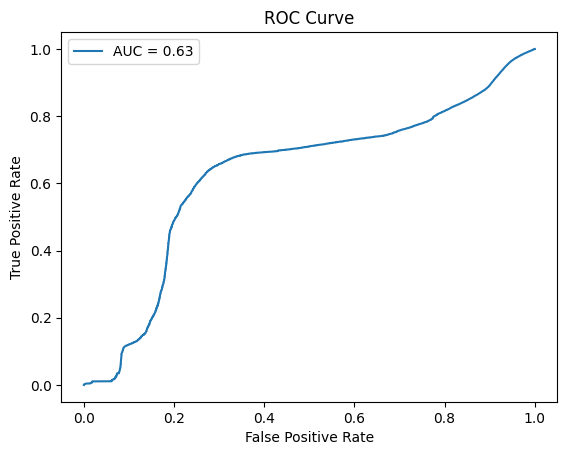

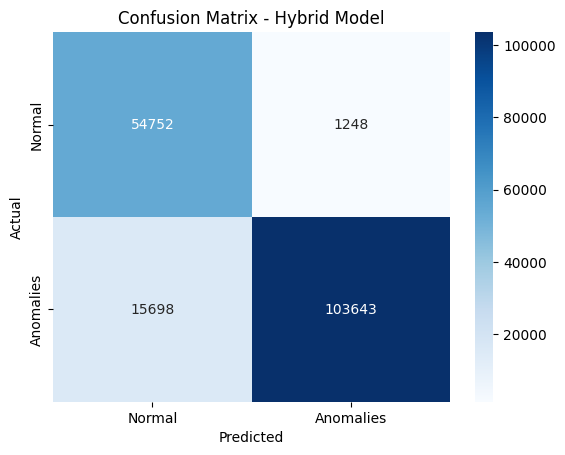

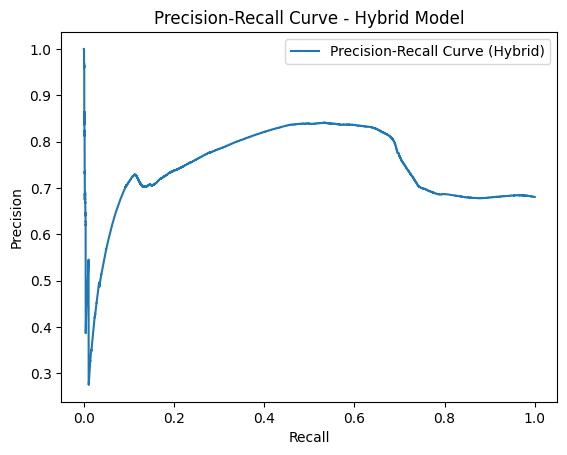

Hybrid Model Precision: 0.9881
Hybrid Model Recall: 0.8685
Hybrid Model F1-Score: 0.9244
Hybrid Model Accuracy: 0.9034


['random_forest_model.pkl']

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load Training and Testing Datasets
train_file = "UNSW_NB15_training-set.csv"
test_file = "UNSW_NB15_testing-set.csv"

unsw_nb15_train = pd.read_csv(train_file)
unsw_nb15_test = pd.read_csv(test_file)

# Identify label column ('label') and drop unnecessary columns
label_column = "label"
X_train = unsw_nb15_train.drop(columns=["id", "attack_cat", "label"])
y_train = unsw_nb15_train[label_column]

X_test = unsw_nb15_test.drop(columns=["id", "attack_cat", "label"])
y_test = unsw_nb15_test[label_column]

# Step 2: Feature Engineering
# Select numeric features only
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

# Remove low variance features
variance_filter = VarianceThreshold(threshold=0.01)
X_train_numeric = variance_filter.fit_transform(X_train_numeric)
X_test_numeric = variance_filter.transform(X_test_numeric)

# Normalize numeric features
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

# One-hot encode categorical features (if any)
categorical_features = X_train.select_dtypes(include=['object']).columns
if len(categorical_features) > 0:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = encoder.fit_transform(X_train[categorical_features])
    X_test_cat = encoder.transform(X_test[categorical_features])
    X_train = np.hstack((X_train_numeric, X_train_cat))
    X_test = np.hstack((X_test_numeric, X_test_cat))
else:
    X_train = X_train_numeric
    X_test = X_test_numeric

# Address Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Step 3: Build the Autoencoder Model
input_dim = X_train.shape[1]
encoding_dim = 32  # Adjust encoding size for better feature representation

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Step 4: Train the Autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0],
                epochs=50, batch_size=64, validation_split=0.2,
                shuffle=True, callbacks=[early_stopping])

# Step 5 (Updated): Detect Anomalies on Training Data
reconstructions_train = autoencoder.predict(X_train)
mse_train = np.mean(np.power(X_train - reconstructions_train, 2), axis=1)

# Dynamically determine the threshold
validation_mse = np.mean(np.power(X_test[y_test == 0] - autoencoder.predict(X_test[y_test == 0]), 2), axis=1)
threshold = np.percentile(validation_mse, 95)

# Predict anomalies
y_pred = [1 if error > threshold else 0 for error in mse]

# Step 6: Use Hybrid Model
# Add mse as a feature to the training data
X_train_autoencoder = np.hstack((X_train, np.expand_dims(mse_train, axis=1)))


# Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_autoencoder, y_train)

# Evaluate Hybrid Model on Test Data
hybrid_reconstructions = autoencoder.predict(X_test)
hybrid_mse = np.mean(np.power(X_test - hybrid_reconstructions, 2), axis=1)
X_test_hybrid = np.hstack((X_test, np.expand_dims(hybrid_mse, axis=1)))

# Make predictions
hybrid_y_pred = rf.predict(X_test_hybrid)

print("Hybrid Model Classification Report:")
print(classification_report(y_test, hybrid_y_pred, digits=4))

# Step 7: Visualization
plt.figure()
fpr, tpr, _ = roc_curve(y_test, hybrid_mse)
roc_auc = roc_auc_score(y_test, hybrid_mse)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()
# Step 7: Visualization of Confusion Matrix
cm = confusion_matrix(y_test, hybrid_y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomalies"], yticklabels=["Normal", "Anomalies"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()

# Step 8: Precision-Recall Curve for Hybrid Model
precision, recall, _ = precision_recall_curve(y_test, hybrid_mse)

plt.figure()
plt.plot(recall, precision, label="Precision-Recall Curve (Hybrid)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Hybrid Model")
plt.legend()
plt.show()

# Step 9: Evaluation Metrics for Hybrid Model
precision_score, recall_score, f1_score, _ = precision_recall_fscore_support(y_test, hybrid_y_pred, average='binary')
accuracy = accuracy_score(y_test, hybrid_y_pred)

print(f"Hybrid Model Precision: {precision_score:.4f}")
print(f"Hybrid Model Recall: {recall_score:.4f}")
print(f"Hybrid Model F1-Score: {f1_score:.4f}")
print(f"Hybrid Model Accuracy: {accuracy:.4f}")

# Save Hybrid Model Results
hybrid_results = {
    "Precision": precision_score,
    "Recall": recall_score,
    "F1-Score": f1_score,
    "Accuracy": accuracy
}
hybrid_results_df = pd.DataFrame([hybrid_results])
hybrid_results_df.to_csv("hybrid_model_results.csv", index=False)

# Save the Random Forest model
import joblib
joblib.dump(rf, "random_forest_model.pkl")